<a href="https://colab.research.google.com/github/yaoshiang/The-Real-World-Weight-Crossentropy-Loss-Function/blob/master/Real_World_Weighted_Crossentropy_Loss_Function.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Real-World-Weighted Crossentropy Loss Function





This is a companion notebook to the paper published at <<<>>>.

Copyright (C) 2019 Yaoshiang Ho

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

Contact author for exceptions, which are intended to be widely granted. 

You should have received a copy of the GNU General Public License
along with this program.  If not, see <https://www.gnu.org/licenses/>.

In [0]:
# Import necessary libraries

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

import numpy as np
from numpy.random import seed

import matplotlib.pyplot as plt

from tensorflow import set_random_seed

import keras.backend as K
from keras.layers import Input, Dense, Dropout
from keras.models import Model
from keras.utils import to_categorical
from keras.optimizers import SGD

import scipy as sp

from tabulate import tabulate

np.set_printoptions(formatter={'float': lambda x: "{0:0.2f}".format(x)})

Using TensorFlow backend.


In [0]:
# Fetch MNIST dataset

mnist = fetch_openml('mnist_784', cache=True)

In [0]:
#Processing on MNIST data
X = mnist.data.astype('float32')
y = mnist.target.astype('int64')
X /= 255.0
X = X
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

In [0]:
def create_model(loss):
  k_y = k_x = Input(shape=(784,))
  k_y = Dense(50, activation='relu')(k_y)
  k_y = Dense(20, activation='relu')(k_y)
  k_y = Dense(10, activation='softmax')(k_y)

  model = Model(inputs=k_x, outputs=k_y)
  model.compile(optimizer='adam', loss=loss, metrics=['categorical_accuracy'])
  return model

# model_a = create_model("categorical_crossentropy")
# set_random_seed(1)
# model_a.fit(x = X_train, y = to_categorical(y_train), epochs=10, batch_size=100, validation_split=0.1)
# print(model_a.evaluate(X_test, to_categorical(y_test)))

In [0]:
def average_predictions(z, y):
  # Inputs: 
  #   z: raw output of softmax for m classes
  #   y: target predictions
  # Outputs:
  #   average predictions matrix of size (z.shape[1],z.shape[1])
  #     axis 0 are the true categories
  #     axis 1 are the predicted categories
  #     each cell is the average of the predictions
  m, n = z.shape
  y_pred = np.argmax(z, axis=1)  
  
  averages = np.zeros((n, n))
  
  for i in range(0, n):
    mask = y == np.array(i)
    assert mask.shape == (m,)
    np.mean(z[mask], axis=0, out=averages[i])
    
  return averages

# print("Average predictions for model_a. Rows are y, columns are y_hat")
# print(average_predictions(model_a.predict(X_test), y_test))

In [0]:
def num_predictions(z, y):
  # Inputs: 
  #   z: raw output of softmax for m classes
  #   y: target predictions using argmax
  # Outputs:
  #   total predictions matrix of size (z.shape[1],z.shape[1])
  #     axis 0 are the true categories
  #     axis 1 are the predicted categories
  #     each cell is the sum of the predictions
  m, n = z.shape
  y_pred = np.argmax(z, axis=1)  
  
  sums = np.zeros((n, n))
  
  for i in range(0, n):
    mask = y == np.array(i)
    assert mask.shape == (m,)    
    np.sum(to_categorical(np.argmax(z[mask], axis=1), num_classes=10), axis=0, out=sums[i])
  return sums

# print("Total number of predictions for model_a. Rows are y, columns are y_hat")
# np.set_printoptions(formatter={'float': lambda x: "{0:6.0f}".format(x)})
# print(num_predictions(model_a.predict(X_test), y_test))
# np.set_printoptions(formatter={'float': lambda x: "{0:0.2f}".format(x)})

In [0]:
# Copyright (C) 2019 Yaoshiang Ho

# This program is free software: you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# This program is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU General Public License for more details.

# You should have received a copy of the GNU General Public License
# along with this program.  If not, see <https://www.gnu.org/licenses/>.

def create_rww_binary_crossentropy(fn_weight, fp_weight):
  """
  binary_crossentropy is a special case of categorical_crossentropy.  
  The "all other" column is imputed. For single-label, an implementation is provided.
  However, this loss function is not very useful in a multi-label environment. 
  It only supports k=1. 
  
  In future work, we will provide
  an implementation for one target, one miscategorization. Note that this will
  require a tensor of at lease size (k,k,2,2), where, the first 2 
  represents T/F of target, the second 2 represents the FP/FN of label. 

  We may also create a fully expressive loss function, which would require some
  efficient representation of a tensor of size (k, k, 2^k, 2^k)
  
  """  
  def binary_loss_function(target, output):
    output = K.clip(output, K.epsilon(), 1 - K.epsilon()) 
    
    logs = K.log(output) # shape (m, 1)
    logs_1_sub = K.log(1-output) # shape (m, 1)

    return - K.mean(target * fn_weight * logs + 
                    (1-target) * fp_weight * logs_1_sub)

  return binary_loss_function

def create_rww_categorical_crossentropy(k, loss_type, fn_weights=None, fp_weights=None, return_weights=False):
  """Real-World-Weighted crossentropy between an output tensor and a target tensor.
  
  The loss_types other than rww_categorical_crossentropy reimplement existing K/TF 
  functions but are not as optimized. 
  Those loss_types are useful when calling return_weights=True, which
  then returns fn and fp weights of size (k,k). Editing those to reflect
  real world costs, then passing them back into create_rww_crossentropy with 
  loss_type "rww_crossentropy" is the recommended appraoch. 
  
  The fn and fp weights are easy to reason about. Suppose you have three classes: cat, dog, and other.
  
  Cat is one-hot encoded as [1,0,0] in a target. 
  
  fn_weights of [x1, __, __]
                [__, x2, __]
                [__, __, x3]
 
  fn_weights only applies to the one-hot in question. We dot to
  
  fn_weights of [x1, __, __]

  x1 represents the scale of the cost for a fn, calculated as fn_weight * log(y_pred)

  ...

  fp_weights is concerned with the costs of the fps from the other classes. 

  fp_weights of [__, x1, x2]
                [x3, __, x4]
                [x5, x6, __]
 
  fp_weights only applies to the zero labels. We again dot against [1, 0, 0]
  
  fp_weights of [__, x1, x2]

  x1 represents the cost of predicting 1 for dog, when it should be zero. (log(1-y_pred))

  
  Args:
    * k: 2 or more for single label, multiclass categorical crossentropy. 
      1 for the special case of binary_crossentropy
    * loss_type: "categorical_crossentropy" to initialize to 
      standard softmax_crossentropy behavior, 
      or "weighted_categorical_crossentropy" for standard behavior, or, 
      or "rww_crossentropy" for full weight matrix of all possible fn/fp combinations. 
      "binary_crossentropy" is available but is not useful in multi-label
      environments. It is only useful for classic binary logistic regression. 
      k must be 2 for binary_crossentropy. fp_weights and fn_weights should
      each be scalars. 
    * fn_weights: a numpy array of 
      shape (k) for standard tf.nn.weighted_crossentropy behavior focusing on 
      false negatives. This will internally be converted to a matrix of (k,k)
      along only the main diagonal by multiplying by identity. 
    * fp_weights: a numpy array of shape (k,k) to define specific combinations 
      of false positive. The main diag should be zeros. 
    * return_weights: If False (default), returns cost function. If True, 
      returns fn and fp weights as np.array. Useful if changes
      necessary before passing back to create_rww_crossentropy. 
Returns:
    * retval: Loss function for use Keras.model.fit, or if return_weights
      arg is True, the fn_weights and fp_weights. 
  """

  full_fn_weights = None
  full_fp_weights = None

  anti_eye = np.ones((k,k)) - np.eye(k)
    
  if (loss_type=="categorical_crossentropy"):
    full_fn_weights = np.identity((k))
    full_fp_weights = np.zeros((k, k)) # Softmax crossentropy ignores fp.

  elif(loss_type=="weighted_categorical_crossentropy"):
    full_fn_weights = np.eye(k) * fn_weights
    full_fp_weights = np.zeros((k, k)) # softmax crossentropy ignores fp
    
  elif(loss_type=="rww_crossentropy"):
    assert not np.count_nonzero(fn_weights * anti_eye)
    assert not np.count_nonzero(fp_weights * np.eye(k))

    full_fn_weights = fn_weights
    # Novel piece: allow any combination of fp.
    full_fp_weights = fp_weights
    
  else:
    raise Exception("unknown loss_type: " + str(loss_type))
   
  fn_wt = K.constant(full_fn_weights) # (k,k), always sparse along main diag. 
  fp_wt = K.constant(full_fp_weights) # (k,k), always dense except main diag. 

  def loss_function(target, output):
    output = K.clip(output, K.epsilon(), 1 - K.epsilon()) 
    
    logs = K.log(output) # shape (m, k), dense. 1 is good. 
    logs_1_sub = K.log(1-output) # shape (m, k), dense. 0 is good. 

    m_full_fn_weights = K.dot(target, fn_wt) # (m,k) . (k, k)
    m_full_fp_weights = K.dot(target, fp_wt) # (m,k) . (k, k)

    return - K.mean(m_full_fn_weights * logs + 
                    m_full_fp_weights * logs_1_sub)
  
  if (return_weights):
    return full_fn_weights, full_fp_weights
  else:
    return loss_function

In [0]:
# Example of categorical_crossentropy. Class behavior. 
fn_weights, fp_weights = create_rww_categorical_crossentropy(5, 'categorical_crossentropy', return_weights=True)
print("softmax cross entropy weights. k=5 classes. Expected output: fn: ones, fp:zeros. ")
print (fn_weights)
print (fp_weights)

# Example of weighted single-label categorical crossentropy. 
fn_weights, fp_weights = create_rww_categorical_crossentropy(5, 'weighted_categorical_crossentropy', np.array([1,2,3,4,5]), return_weights=True)
print("weighted softmax crossentropy. k=5 classes. Expected output: fn: weights, fp: zeros. ")
print (fn_weights)
print (fp_weights)


# Example of full weighted multi-label categorical crossentropy
fn_weights, fp_weights = create_rww_categorical_crossentropy(10, "categorical_crossentropy", return_weights=True)
fp_weights[5, 8] = 19
loss = create_rww_categorical_crossentropy(10, "rww_crossentropy", fn_weights, fp_weights)
print("real world weighted cross entropy weights. k=10 classes. If target label if 5, heavily penalize a (false positive) 8. ")
print (fn_weights)
print (fp_weights)

print(loss)

softmax cross entropy weights. k=5 classes. Expected output: fn: ones, fp:zeros. 
[[1.00 0.00 0.00 0.00 0.00]
 [0.00 1.00 0.00 0.00 0.00]
 [0.00 0.00 1.00 0.00 0.00]
 [0.00 0.00 0.00 1.00 0.00]
 [0.00 0.00 0.00 0.00 1.00]]
[[0.00 0.00 0.00 0.00 0.00]
 [0.00 0.00 0.00 0.00 0.00]
 [0.00 0.00 0.00 0.00 0.00]
 [0.00 0.00 0.00 0.00 0.00]
 [0.00 0.00 0.00 0.00 0.00]]
weighted softmax crossentropy. k=5 classes. Expected output: fn: weights, fp: zeros. 
[[1.00 0.00 0.00 0.00 0.00]
 [0.00 2.00 0.00 0.00 0.00]
 [0.00 0.00 3.00 0.00 0.00]
 [0.00 0.00 0.00 4.00 0.00]
 [0.00 0.00 0.00 0.00 5.00]]
[[0.00 0.00 0.00 0.00 0.00]
 [0.00 0.00 0.00 0.00 0.00]
 [0.00 0.00 0.00 0.00 0.00]
 [0.00 0.00 0.00 0.00 0.00]
 [0.00 0.00 0.00 0.00 0.00]]
real world weighted cross entropy weights. k=10 classes. If target label if 5, heavily penalize a (false positive) 8. 
[[1.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00]
 [0.00 1.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00]
 [0.00 0.00 1.00 0.00 0.00 0.00 0.00 0.00 0

In [0]:
def generate_unequal_pair(i):
  np.random.seed(i)
  a = np.random.randint(0, 10)
  b = np.random.randint(0,10)
  while a == b:
    b = np.random.randint(0,10)
  return a, b

# Repeatability
np.random.seed(1)
set_random_seed(1)

# Quick compare 10 sample and 10 control networks
for i in range(0,10):
  print(".", end = " ")   
  # Generate random socially biased or expensive fn,fp pair, setup rww_crossentropy loss function. 
  on_label, offensive_fp = generate_unequal_pair(i)  
  fn_weights, fp_weights = create_rww_categorical_crossentropy(10, "categorical_crossentropy", return_weights=True)
  fp_weights[on_label, offensive_fp] = 19
  loss = create_rww_categorical_crossentropy(10, "rww_crossentropy", fn_weights, fp_weights)

  # Train control model
  model_control = create_model('binary_crossentropy') # K/TF builtin
  model_control.fit(x = X_train, y = to_categorical(y_train), epochs=10, batch_size=100, validation_split=0.1, verbose=0)
  num_pred_control = num_predictions(model_control.predict(X_test), y_test)
  _, acc_control = model_control.evaluate(X_test, to_categorical(y_test))
  
  # Train experimental model with same epochs / batchsize as control model. 
  model_test = create_model(loss) # RWW version
  model_test.fit(x = X_train, y = to_categorical(y_train), epochs=10, batch_size=100, validation_split=0.1, verbose=0)  
  num_pred_test = num_predictions(model_test.predict(X_test), y_test)
  _, acc_test = model_test.evaluate(X_test, to_categorical(y_test), verbose=0)

  print("For test (fn:fp):(" + str(on_label) + "," + \
        str(offensive_fp) + "): FPs from (control, experimental): (" + \
        str(num_pred_control[on_label, offensive_fp]) + "," +\
        str(num_pred_test[on_label, offensive_fp]) + \
        "); Accuracy from (control, experimental):" + \
        '{:0.4f}'.format(acc_control) + ",", '{:0.4f}'.format(acc_test) + ")")

. Train on 47250 samples, validate on 5250 samples
Epoch 1/10
47250/47250 [==============================] - 3s 64us/step - loss: 0.0745 - categorical_accuracy: 0.8695 - val_loss: 0.0421 - val_categorical_accuracy: 0.9270
Epoch 2/10
47250/47250 [==============================] - 3s 56us/step - loss: 0.0349 - categorical_accuracy: 0.9401 - val_loss: 0.0335 - val_categorical_accuracy: 0.9451
Epoch 3/10
47250/47250 [==============================] - 3s 57us/step - loss: 0.0277 - categorical_accuracy: 0.9539 - val_loss: 0.0288 - val_categorical_accuracy: 0.9510
Epoch 4/10
47250/47250 [==============================] - 3s 57us/step - loss: 0.0237 - categorical_accuracy: 0.9607 - val_loss: 0.0259 - val_categorical_accuracy: 0.9571
Epoch 5/10
47250/47250 [==============================] - 3s 55us/step - loss: 0.0204 - categorical_accuracy: 0.9658 - val_loss: 0.0249 - val_categorical_accuracy: 0.9592
Epoch 6/10
47250/47250 [==============================] - 3s 57us/step - loss: 0.0181 - catego

KeyboardInterrupt: ignored

In [0]:
# Train 90 control and 90 experimental models. 

# Repeatability
np.random.seed(1)
set_random_seed(1)

accs = []
fps = []
preds = []
ws = []

for i in range(0,10):
  for j in range (0,10):
    if i == j: 
      continue

    print(".", end = " ")   
    fn_weights, fp_weights = create_rww_categorical_crossentropy(10, "categorical_crossentropy", return_weights=True)
    fp_weights[i, j] = 19
    loss = create_rww_categorical_crossentropy(10, "rww_crossentropy", fn_weights, fp_weights)

    # Train control model
    model_control = create_model('binary_crossentropy') # K/TF builtin
    model_control.fit(x = X_train, y = to_categorical(y_train), epochs=10, batch_size=100, validation_split=0.1, verbose=0)
    num_pred_control = num_predictions(model_control.predict(X_test, verbose=0), y_test)
    _, acc_control = model_control.evaluate(X_test, to_categorical(y_test), verbose=0)
 
    # Train experimental model with same epochs / batchsize as control model. 
    model_test = create_model(loss) # RWW version
    model_test.fit(x = X_train, y = to_categorical(y_train), epochs=10, batch_size=100, validation_split=0.1, verbose=0)  
    num_pred_test = num_predictions(model_test.predict(X_test, verbose=0), y_test)
    _, acc_test = model_test.evaluate(X_test, to_categorical(y_test), verbose=0)

    accs.append((acc_control, acc_test))
    fps.append((num_pred_control[i, j], num_pred_test[i,j]))
    preds.append((num_pred_control, num_pred_test))
    ws.append((fn_weights, fp_weights))

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

In [0]:
print(fps.shape)

(90, 2)


In [0]:
# Perform t-test on results (number of mislabels). We use Welch's test since the variances are different. 

fps = np.array(fps)
statistic, pvalue = sp.stats.ttest_ind(fps[:,0], fps[:,1], equal_var=False)

print(np.mean(fps[:,0]))
print(np.mean(fps[:,1]))

print(statistic)
print(pvalue)

6.511111111111111
2.533333333333333
5.739868646596386
6.979155459424445e-08


In [0]:
# Perform t-test on errors

accs = np.array(accs)
statistic, pvalue = sp.stats.ttest_ind(1. - accs[:,0], 1. - accs[:,1])

print(np.mean(1. - accs[:,0]))
print(np.mean(1. - accs[:,1]))

print(statistic)
print(pvalue)

0.03562285713771032
0.03624444443278843
-2.232330137956822
0.02684018059521198


In [0]:
# Calculate Real World Cost
def clip_correct(preds):
  k = preds.shape[0]
  assert k == preds.shape[1]
  
  anti_eye = 1 - np.eye(k)
  return preds * anti_eye # k,k, with the main diagonal masked out to zeros

def categorical_real_world_cost(preds, fn_ws, fp_ws):
  k = preds.shape[0]
  assert k == preds.shape[1]
  
  false_preds = clip_correct(preds)
  fn_cost = np.sum(np.sum(false_preds, axis=-1) * np.sum(fn_ws, axis=-1)) 
  fp_cost = np.sum(false_preds * fp_ws)
 
  return (fn_cost + fp_cost) / np.sum(preds)

def vector_categorical_real_world_cost(m, preds, fn_ws, fp_ws):
  retval = np.zeros(m)
  for i in range(0,m):
    retval[i] = categorical_real_world_cost(preds[i], fn_ws[i], fp_ws[i])
  return retval
    
fn_ws = np.array(ws)[:,0,:,:] # size (90, k, k)
fp_ws = np.array(ws)[:,1,:,:] # size (90, k, k)

preds_c = np.array(preds)[:,0,:,:] # size (90, k, k)
preds_t = np.array(preds)[:,1,:,:] # size (90, k, k)

costs_c = vector_categorical_real_world_cost(90, preds_c, fn_ws, fp_ws)
costs_t = vector_categorical_real_world_cost(90, preds_t, fn_ws, fp_ws)

assert costs_c.shape == (90,)
assert costs_t.shape == (90,)

print(np.mean(costs_c))
print(np.mean(costs_t))

statistic, pvalue = sp.stats.ttest_ind(costs_c, costs_t)
print(statistic)
print(pvalue)


0.04269206349206349
0.03899492063492063
4.46785326959378
1.4015370329833121e-05


# Testing against imbalanced binary data



In [0]:
# Fetch MNIST dataset

# mnist = fetch_openml('mnist_784', cache=False)

#Processing on MNIST data
X = mnist.data.astype('float32')
y = mnist.target.astype('int64')
X /= 255.0

def create_imbalanced_mnist_data(X, y, target, num_minority):
  new_X, new_y = [], []
  
  mask = y == target
  anti_mask = y != target

  X_label = X[mask]  
  y_label = y[mask]
    
  X_label = X[mask]
  np.random.seed(1)
  np.random.shuffle(new_X)
  X_label = X_label[0:num_minority,:]
  
  new_X = np.concatenate([X_label, X[anti_mask]])
  new_y = np.concatenate([np.ones((num_minority)), np.zeros(X[anti_mask].shape[0])])
  
  return new_X, new_y
  
X, y = create_imbalanced_mnist_data(X, y, 5, 700)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

In [0]:
def create_binary_model(loss):
  np.random.seed(1)
  set_random_seed(1)

  k_y = k_x = Input(shape=(784,))
  # k_y = Dense(100, activation='relu')(k_y)
  k_y = Dense(50, activation='relu')(k_y)
  k_y = Dense(10, activation='relu')(k_y)
  k_y = Dense(1, activation='sigmoid')(k_y)

  model = Model(inputs=k_x, outputs=k_y)
  model.compile(optimizer='adam', loss=loss, metrics=['binary_accuracy'])
  return model
  
FN_MARGINAL_COST = 2000 # E.g. if the disease is missed, it will get worse, costing an extra $2000 in future medical costs and pain and suffering
FP_MARGINAL_COST = 100 # E.g. marginal cost of FP is the cost of running a second, more expensive test to identify the TN. 

model_control = create_binary_model('binary_crossentropy')

loss = create_rww_binary_crossentropy(FN_MARGINAL_COST, FP_MARGINAL_COST)
model_test = create_binary_model(loss)

model_control.fit(x = X_train, y = y_train, epochs=10, batch_size=100, validation_split=0.1, verbose=1)  
model_test.fit(x = X_train, y = y_train, epochs=10, batch_size=100, validation_split=0.1, verbose=1)  

W0904 14:34:32.525773 140544463857536 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0904 14:34:32.527151 140544463857536 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0904 14:34:32.536085 140544463857536 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0904 14:34:32.582772 140544463857536 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:793: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0904 14:34:32.606411 140544463857536 deprecation_wrappe

Train on 43461 samples, validate on 4829 samples
Epoch 1/10
43461/43461 [==============================] - 7s 156us/step - loss: 0.0467 - binary_accuracy: 0.9901 - val_loss: 0.0190 - val_binary_accuracy: 0.9954
Epoch 2/10
43461/43461 [==============================] - 2s 52us/step - loss: 0.0179 - binary_accuracy: 0.9949 - val_loss: 0.0128 - val_binary_accuracy: 0.9959
Epoch 3/10
43461/43461 [==============================] - 2s 52us/step - loss: 0.0125 - binary_accuracy: 0.9964 - val_loss: 0.0111 - val_binary_accuracy: 0.9969
Epoch 4/10
43461/43461 [==============================] - 2s 50us/step - loss: 0.0092 - binary_accuracy: 0.9971 - val_loss: 0.0087 - val_binary_accuracy: 0.9973
Epoch 5/10
43461/43461 [==============================] - 2s 51us/step - loss: 0.0072 - binary_accuracy: 0.9980 - val_loss: 0.0087 - val_binary_accuracy: 0.9975
Epoch 6/10
43461/43461 [==============================] - 2s 51us/step - loss: 0.0056 - binary_accuracy: 0.9983 - val_loss: 0.0085 - val_binary_a

                P      N    TP    FN     TN    FP    Recall    Precision        F1    Real World Cost    Real World Benefit
------------  ---  -----  ----  ----  -----  ----  --------  -----------  --------  -----------------  --------------------
Control       180  15917   147    33  15909     8  0.816667     0.948387  0.877612           4.149842             18.214574
Control_adj   180  15917   154    26  15906    11  0.855556     0.933333  0.892754           3.298751             19.065664
Experimental  180  15917   169    11  15843    74  0.938889     0.695473  0.799054           1.826427             20.537988


Text(0.5, 1.0, 'F1 Score by Threshhold')

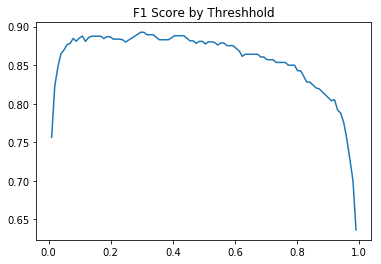

In [0]:
def binary_real_world_cost(fn, fp, fn_cost, fp_cost):
  return fn*fn_cost + fp*fp_cost

def binary_stats(z, y, threshold, fn_cost, fp_cost):
  z = np.squeeze(z)

  y_pred = z > threshold
  p = np.count_nonzero(y)
  n = np.count_nonzero(1.-y)

  tp = np.count_nonzero(y_pred * y)
  fn = np.count_nonzero((1.-y_pred) * y)
  tn = np.count_nonzero((1.-y_pred) * (1.-y))
  fp = np.count_nonzero(y_pred * (1.-y))

  recall = np.float64(tp) / (tp + fn) 
  precision = np.float64(tp) / (tp + fp)
  f1 = np.float64(2 * recall * precision) / (recall + precision)
  rwc = (binary_real_world_cost (fn, fp, fn_cost, fp_cost)) / (p+n)
  rwb = (p * fn_cost) / (p+n) - rwc
  
  return p, n, tp, fn, tn, fp, recall, precision, f1, rwc, rwb

# This is the algorithm to fine tune the threshold hyperparameter after training. 
def search_threshold(z, y):
  best_t = 0;
  best_f1 = 0

  data = []
  
  for i in np.linspace(0.01, .99, num=100):
    _, _, _, _, _, _, _, _, f1, _, _ = binary_stats(z, y, i, 0, 0)
    data.append((i, f1))
    if f1 > best_f1:
      best_f1 = f1
      best_t = i  
  return best_t, data

y_pred_c = model_control.predict(X_test)
y_pred_t = model_test.predict(X_test)

stats_control = binary_stats(y_pred_c, y_test, 0.5, FN_MARGINAL_COST, FP_MARGINAL_COST)
best_threshold, data = search_threshold(y_pred_c, y_test)
stats_control_adj = binary_stats(y_pred_c, y_test, best_threshold, FN_MARGINAL_COST, FP_MARGINAL_COST)
stats_test = binary_stats(y_pred_t, y_test, 0.5, FN_MARGINAL_COST, FP_MARGINAL_COST)

print(tabulate([('Control',) + stats_control, \
                ('Control_adj',) + stats_control_adj, \
                ('Experimental',) + stats_test], \
               headers=['P', 'N', 'TP', "FN", "TN", "FP", "Recall", "Precision", "F1", "Real World Cost", "Real World Benefit"], floatfmt=".6f"))

plt.plot(np.array(data)[:,0], np.array(data)[:,1])
plt.title('F1 Score by Threshhold')
# ax.set(xlabel='Threshold', ylabel='F1',
#        title='F1 Score by Threshold')

# Graphical Display of Loss Function Mechanics

(1000, 2)


Text(0, 0.5, 'Loss')

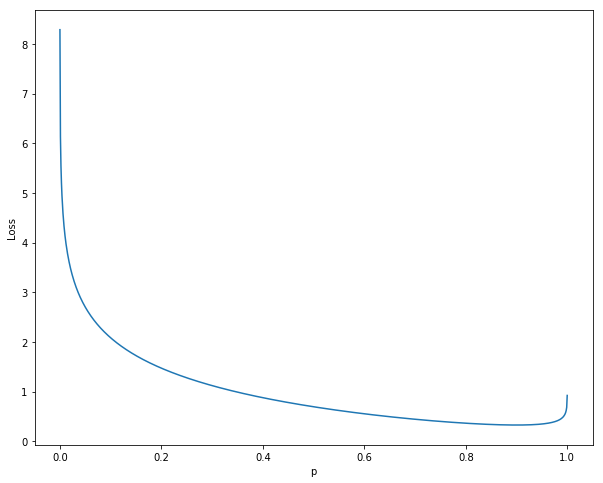

In [0]:
def J(z, y):
  if (y==1):
    return -np.log(z)
  elif (y==0):
    return -np.log(1-z)
  else:
    assert false

def J_batch(p, n_h, n_t):
  m = n_h + n_t
  x = np.zeros(m)

  for i in range(0,n_h):
    x[i] = 1

  retval = 0.
  for i in range(0, m):
    retval += J(p, x[i])
  retval /= x.shape[0]
  return retval

x_and_y = []
    
for i in np.linspace(0.0001, 0.9999, 1000):
  x_and_y.append((i, J_batch(i, 9, 1)))

x_and_y = np.array(x_and_y)

print(x_and_y.shape)
  
fig = plt.figure(figsize=(10,8))
plt.plot(x_and_y[:,0], x_and_y[:,1])
plt.xlabel('p')
plt.ylabel('Loss')


# Bernoulli Trial

A quick Bernoulli trial. Bias should be close to 2.1. Sigmoid(2.1) = 0.9, which is the minimum cost / accurate prediction for 9 heads and 1 tail. 

In [0]:
k_y = k_x = Input(shape=(1,))
k_y = Dense(1, activation='sigmoid', kernel_initializer='zeros',
                bias_initializer='ones')(k_y)

model_bernoulli = Model(inputs=k_x, outputs=k_y)
model_bernoulli.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])

X = np.zeros((10,))
y = np.concatenate([np.ones((9,)), np.zeros((1,))])

model_bernoulli.fit(x = X, y = y, epochs=1000, verbose=0) 
print(model_bernoulli.evaluate(x = X, y = y))
print(model_bernoulli.get_weights()[1])

def sigmoid(x): return 1 / (1 + np.exp(-x))

print(sigmoid(model_bernoulli.get_weights()[1][0]))


10/10 [==============================] - 1s 57ms/step
[0.33526673913002014, 0.8999999761581421]
[1.75]
0.8518410365873759
